# Genetic Algorithm per la risoluzione del problema di Pompei-Orienteering

## Accenno alla metaeuristica Genetic Algorithm

In un algoritmo genetico, una popolazione di **soluzioni candidate (chiamate individui)** a un problema di ottimizzazione evolvono verso soluzioni migliori. Ogni soluzione candidata ha un insieme di proprietà (i suoi cromosomi o genotipo) che possono essere mutate e alterate;

L'evoluzione di solito inizia da una popolazione di individui generati casualmente ed è un processo iterativo, con **la popolazione in ogni iterazione chiamata generazione**. In ogni generazione viene valutata la forma fisica (**fitness**) di ogni individuo della popolazione; l'idoneità è solitamente il valore della funzione obiettivo nel problema di ottimizzazione da risolvere. Gli individui più in forma vengono selezionati stocasticamente dalla popolazione attuale e il genoma di ogni individuo viene **mutato** (in modo casuale o secondo un criterio) per formare una **nuova generazione**. La nuova generazione di soluzioni candidate viene quindi utilizzata nell'iterazione successiva dell'algoritmo. Comunemente, **l'algoritmo termina quando è stato prodotto un numero massimo di generazioni** o quando è stato raggiunto un livello di fitness soddisfacente per la popolazione dove ogni soluzione candidata presenterà la stessa fitness.

Un tipico algoritmo genetico richiede:

 - una rappresentazione genetica del dominio della soluzione;
 - una funzione di fitness per valutare il dominio della soluzione;
 - una rappresentazione standard di ciascuna soluzione candidata è un array di bit (chiamato anche set di bit o stringa di bit).

Una volta definita la rappresentazione genetica e la funzione di fitness, un **GA procede ad inizializzare una popolazione di soluzioni e quindi a migliorarla attraverso l'applicazione ripetitiva degli operatori di mutazione, crossover, inversione e selezione.**

#### Lettura dati dal .csv

Per il test del modello è possibile testare le seguenti istanze per il benchmark:
- Bench32 
- Bench52
- Bench102

Per il test del modello per l'applicazione reale inserire nella riga "namefile" le seguenti istante create dagli autori:
- Scavi_Archeologici_Pompei_Anfiteatro_Misteri
- Scavi_Archeologici_Pompei_Marina_Misteri
- Scavi_Archeologici_Pompei_Marina_Anfiteatro

*N.B* Le istanze dell'applicazione reale sono state scelte sulla base di differenti start_point e end_point

In [1]:
import pandas as pd
import numpy as np


#Parametri del problema
DMAX=0.03
population=100
max_number_of_generation=10
K=4
tsize=4

namefile = 'Scavi_Archeologici_Pompei_Marina_Anfiteatro'

node_list = []
with open('./IstanzeBenchmark/' + namefile + '.txt') as file:
    
    if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
        namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
        namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro"):
        zoom=16
        for i, line in enumerate(file):
            node = line.split(',')
            node_list.append([str(node[0]),float(node[1]),float(node[2]),int(node[3])])

    else:
        zoom=5
        for i, line in enumerate(file):
            node = line.split(',')
            node_list.append([str(i),float(node[0]),float(node[1]),int(node[2])])

node_info = np.asarray(node_list,dtype=object)
node = pd.DataFrame(data=node_info,columns=['Nodo','Longitudine','Latitudine','Score'])

In [2]:
import random

#Definizione della classe individuo e i suoi metodi
class individual:
    """
    Definisco una classe relativi agli individui della popolazione.
    - node_list: Lista dei nodi.
    - visited: Nodi visitati.
    - unvisited: Nodi non visitati.
    - fitness: Fitness dell'individuo.
    - distance: Distanze adiacenti nel percorso.
    - TotalDistance: Distanza totale del percorso.
    - TotalPoint: Punteggio totale del percorso.
    """
    def __init__(self):
        self.node_list=np.array([node.iloc[0],node.iloc[-1]])
        self.visited=self.node_list.copy()
        self.unvisited=np.array(node.iloc[1:-1])
        self.fitness=0
        self.distance=self.cal_distance()
        self.TotalDistance=self.distance.sum()
        self.TotalPoint=0

    def reset(self,node_list,visited,unvisited,distance,TotalDistance,TotalPoint):
        self.node_list=node_list
        self.visited=visited
        self.unvisited=unvisited
        self.distance=distance
        self.TotalDistance=TotalDistance
        self.TotalPoint=TotalPoint

    #Calcolo della distanza tra due punti
    def path_length(self,x1,x2,y1,y2):
        x=(x1-x2)**2
        y=(y1-y2)**2
        return np.sqrt(x+y)

    def cal_distance(self):
        distance=[]
        number_of_nodes = self.node_list.shape[0]
        for i in range(number_of_nodes - 1):
            D=self.path_length(self.node_list[i,1],self.node_list[i+1,1],self.node_list[i,2],self.node_list[i+1,2])
            distance.append(D)
        distance=np.array(distance)
        return distance

    def cal_TotalDistance(self):
        self.TotalDistance=self.distance.sum()

    def cal_TotalPoint(self):
        number_of_nodes = self.node_list.shape[0]
        for i in range(number_of_nodes):
            self.TotalPoint+=self.node_list[i,3]

    #Calcolo della fitness
    #La valutazione è Fitness_i = TotalPoint^3 / TotalDistance
    def cal_fitness(self):
        if self.TotalPoint==0:
            self.fitness=0
        else:
            self.fitness=self.TotalPoint**3/self.TotalDistance

    def insert_repeat_node(self):
        index=random.randint(0,len(self.visited)-1)
        insert_node=self.visited[index,:]
        insert_loc=len(self.node_list)-1
        self.node_list=np.insert(self.node_list,insert_loc,insert_node,axis=0)

        self.distance=self.cal_distance()
        self.cal_TotalDistance()

        self.cal_fitness()

In [3]:
import copy


#Funzione che calcola la distanza euclidea tra 2 individui
def cal_distant(x1,y1,x2,y2):
    x=(x1-x2)**2
    y=(y1-y2)**2
    return np.sqrt(x+y)

#Funzione di inserimento di un nodo
def insert_vertex(insert_location,node_list_temp,node_distance_temp,node_visited_temp,node_unvisited_temp,node_TotalPoint_temp,insert_node=np.array([-1,-1,-1,-1])):
    delete=False
    
    #Scelgo casualmente un nodo non sul percorso
    if insert_node[0]==-1:
        insert_node_index = random.randint(0, node_unvisited_temp.shape[0] - 1)
        insert_node=node_unvisited_temp[insert_node_index,:].copy()
        delete=True
    #Se il nodo è visitato, aggiorno il suo indice con il valore dell'ordine di visita
    else:
        i=0
        while i<len(node_unvisited_temp):
            if node_unvisited_temp[i,0]==insert_node[0]:
                insert_node_index=i
                delete=True
                break
            i+=1

    #Inserisco il punto nella posizione specificata
    node_list_temp=np.insert(node_list_temp,insert_location,insert_node,axis=0)

    #Aggiorno il valore di visited/unvisited/totalpoint
    if delete:
        node_visited_temp=np.insert(node_visited_temp,0,insert_node,axis=0)
        node_unvisited_temp=np.delete(node_unvisited_temp,insert_node_index,axis=0)
        node_TotalPoint_temp+=insert_node[3]

    #Aggiorno la distanza
    dis_front=cal_distant(insert_node[1],insert_node[2],node_list_temp[insert_location-1,1],node_list_temp[insert_location-1,2])
    dis_back=cal_distant(insert_node[1],insert_node[2],node_list_temp[insert_location+1,1],node_list_temp[insert_location+1,2])
    temp_list=np.array([dis_front,dis_back])
    node_distance_temp=np.insert(node_distance_temp,insert_location,temp_list)
    node_distance_temp=np.delete(node_distance_temp,insert_location-1)
    node_TotalDistance_temp=np.sum(node_distance_temp)

    return node_list_temp,node_visited_temp,node_unvisited_temp,node_TotalPoint_temp,node_distance_temp,node_TotalDistance_temp


def crossover(parent1,parent2,i,j):
    # Genero un elenco di nodi figli
    child1_node=parent1.node_list[1:i,:]
    child1_node=np.append(child1_node,parent2.node_list[j:-1,:],axis=0)
    child2_node = parent2.node_list[1:j, :]
    child2_node = np.append(child2_node, parent1.node_list[i:-1, :], axis=0)

    #Creo due nuovi individui
    child1=individual()
    child2=individual()

    child1_node_list, child1_distance,child1_node_visited, child1_node_unvisited, child1_TotalPoint, \
    child1_TotalDistance=child1.node_list,child1.distance,child1.visited,child1.unvisited,\
                          child1.TotalPoint,child1.TotalDistance

    child2_node_list, child2_distance, child2_node_visited, child2_node_unvisited, child2_TotalPoint, \
    child2_TotalDistance = child2.node_list, child2.distance, child2.visited, child2.unvisited, \
                           child2.TotalPoint, child2.TotalDistance

    for x in range(len(child1_node)):
        child1_node_list,child1_node_visited,child1_node_unvisited,child1_TotalPoint,\
        child1_distance,child1_TotalDistance = insert_vertex(x+1,child1_node_list, child1_distance,child1_node_visited,
                                                             child1_node_unvisited, child1_TotalPoint,child1_node[x,:])

    child1.reset( child1_node_list,child1_node_visited,child1_node_unvisited,\
        child1_distance,child1_TotalDistance,child1_TotalPoint)
    child1.cal_fitness()

    for y in range(len(child2_node)):
        child2_node_list,child2_node_visited,child2_node_unvisited,child2_TotalPoint,\
        child2_distance,child2_TotalDistance = insert_vertex(y+1,child2_node_list, child2_distance, child2_node_visited, child2_node_unvisited,
                                                             child2_TotalPoint,child2_node[y,:])

    child2.reset(child2_node_list,child2_node_visited,child2_node_unvisited,\
                    child2_distance,child2_TotalDistance,child2_TotalPoint)
    child2.cal_fitness()

    return child1,child2

#TwoOpt per attuare la mutazione
def TwoOpt(old_individual,DMAX):
    length=len(old_individual.node_list)
    if length<=4:
        return old_individual
    s_node_index=random.randint(1,length-3)
    e_node_index=random.randint(2,length-2)
    while e_node_index<=s_node_index:
        e_node_index=random.randint(2,length-2)

    new_individual=individual()
        
    #Sottostringa da scambiare
    sub_sequence=copy.deepcopy(old_individual.node_list[s_node_index:e_node_index+1,:])
    new_node_list,  new_distance,new_node_visited, new_node_unvisited, new_TotalPoint,\
    new_TotalDistance=new_individual.node_list,new_individual.distance,new_individual.visited,new_individual.unvisited,\
                        new_individual.TotalPoint,new_individual.TotalDistance
    
    #Il primo e l'ultimo elemento del nuovo individuo sono gli stessi
    for i in range(s_node_index-1):
        insert_node=copy.deepcopy(old_individual.node_list[i+1])
        new_node_list,new_node_visited,  new_node_unvisited, new_TotalPoint,new_distance, \
        new_TotalDistance=insert_vertex(i+1,new_node_list,new_distance,new_node_visited,  new_node_unvisited, new_TotalPoint, \
                        insert_node)
    
    #Scambio della prima sequenza
    i=e_node_index-s_node_index
    while i>=0:

        temp_length=len(new_node_list)
        insert_location=temp_length-1
        insert_node=copy.deepcopy(sub_sequence[i,:])
        new_node_list,  new_node_visited, new_node_unvisited, new_TotalPoint, new_distance,\
        new_TotalDistance = insert_vertex(insert_location, new_node_list, new_distance, new_node_visited, new_node_unvisited,
                                          new_TotalPoint, \
                                          insert_node)
        i-=1

    #Scambio della seconda sequenza
    i=e_node_index+1
    while i<=length-2:
        insert_node=copy.deepcopy(old_individual.node_list[i,:])
        temp_length = len(new_node_list)
        insert_location = temp_length - 1
        new_node_list,  new_node_visited, new_node_unvisited, new_TotalPoint, new_distance,\
        new_TotalDistance = insert_vertex(insert_location, new_node_list, new_distance, new_node_visited,
                                          new_node_unvisited,
                                          new_TotalPoint, \
                                          insert_node)
        i+=1

    #Verifico che il nuovo individuo rispetti il vincolo sulla distanza massima
    if new_TotalDistance>DMAX:
        return old_individual

    new_individual.reset(new_node_list,new_node_visited, new_node_unvisited,new_distance,new_TotalDistance,new_TotalPoint)
    new_individual.cal_fitness()

    return new_individual


def inserting_mutation(old_solution,DMAX):
    from random import choice
    in_element_index= random.randint(0, old_solution.unvisited.shape[0] - 1)
    in_element=old_solution.unvisited[in_element_index,:].copy()
    in_value=in_element[3]
    loc=0
    best_increase_value=0
    old_solution_TotalDistance=old_solution.TotalDistance
    for i in range(1,len(old_solution.node_list)):
        old_node_list,  old_node_visited, old_node_unvisited, old_TotalPoint,old_distance, \
        old_TotalDistance = old_solution.node_list,  old_solution.visited, old_solution.unvisited, \
                              old_solution.TotalPoint, old_solution.distance,old_solution.TotalDistance
        old_node_list,old_node_visited,old_node_unvisited,old_TotalPoint,\
        old_distance,old_TotalDistance= insert_vertex(i,old_node_list, old_distance, old_node_visited, old_node_unvisited, old_TotalPoint, \
        in_element)
        increase=(old_TotalDistance-old_solution_TotalDistance)
        insertion_value=in_value**2/increase
        if insertion_value>best_increase_value and old_TotalDistance<DMAX:
            best_increase_value=insertion_value
            loc=i
    old_node_list,  old_node_visited, old_node_unvisited, old_TotalPoint,old_distance, \
    old_TotalDistance = old_solution.node_list,  old_solution.visited, old_solution.unvisited, \
                        old_solution.TotalPoint, old_solution.distance,old_solution.TotalDistance
    if loc!=0:
        new_node_list, new_node_visited, new_node_unvisited, new_TotalPoint, new_distance,\
        new_TotalDistance=insert_vertex(loc,old_node_list, old_distance, old_node_visited, old_node_unvisited, old_TotalPoint, \
    in_element)
        new_individual=individual()
        new_individual.reset(new_node_list, new_node_visited, new_node_unvisited, new_distance, \
        new_TotalDistance, new_TotalPoint)
        new_individual.cal_fitness()
        return new_individual
    return old_solution


def delete_mutation(old_individual,DMAX):
    #Verifico se ci sono elementi duplicati nell'individuo mutato
    temp_list=old_individual.node_list
    node_index_list=[]
    
    #Variabili di conteggio
    i=1
    k=0
    flag=0
    repeat_loc1=0
    repeat_loc2=0

    while i<=len(temp_list)-2:
        if k==0:
            node_index_list.append([temp_list[i,0],i])
            k+=1
        else:
            l=0
            for j in node_index_list:
                if temp_list[i,0]==j[0] and l!=k-1:
                    l+=j[1]
                    flag+=1
                    break

        if flag==0:
            node_index_list.append([temp_list[i,0],i])
            k+=1
        else:
            repeat_loc1+=i
            repeat_loc2+=l
            break
            
        i+=1
    
    #Elimina gli elementi duplicati nell'individuo
    if flag==1:
        new_individual1=individual()
        new_individual2=individual()

        new1_node_list, new1_node_visited, new1_node_unvisited, new1_TotalPoint, new1_distance, \
        new1_TotalDistance = new_individual1.node_list, new_individual1.visited, new_individual1.unvisited, \
                            new_individual1.TotalPoint, new_individual1.distance, new_individual1.TotalDistance

        new2_node_list, new2_node_visited, new2_node_unvisited, new2_TotalPoint, new2_distance, \
        new2_TotalDistance = new_individual2.node_list, new_individual2.visited, new_individual2.unvisited, \
                             new_individual2.TotalPoint, new_individual2.distance, new_individual2.TotalDistance
        
        #Rimuove la prima posizione duplicata
        m=1
        loc=1
        while m<=len(temp_list)-2:

            if m!=repeat_loc1:
                new1_node_list, new1_node_visited, new1_node_unvisited, new1_TotalPoint, new1_distance, \
                new1_TotalDistance = insert_vertex(loc, new1_node_list, new1_distance, new1_node_visited, new1_node_unvisited,
                                                  new1_TotalDistance, \
                                                  temp_list[m,:])
                loc+=1
            m+=1

        new_individual1.reset(new1_node_list, new1_node_visited, new1_node_unvisited, new1_distance, \
        new1_TotalDistance, new1_TotalPoint)
        new_individual1.cal_fitness()

        #Rimuove la seconda posizione duplicata
        n=1
        loc=1
        while n <= len(temp_list) - 2:
            if n != repeat_loc2:
                new2_node_list, new2_node_visited, new2_node_unvisited, new2_TotalPoint, new2_distance, \
                new2_TotalDistance = insert_vertex(loc, new2_node_list, new2_distance, new2_node_visited,
                                                   new2_node_unvisited,
                                                   new2_TotalDistance, \
                                                   temp_list[n, :])
                loc+=1
            n+=1

        new_individual2.reset(new2_node_list, new2_node_visited, new2_node_unvisited, new2_distance, \
                              new2_TotalDistance, new2_TotalPoint)
        new_individual2.cal_fitness()

        if new_individual1.TotalDistance<new_individual2.TotalDistance:
            return new_individual1
        else:
            return new_individual2

    else:
        #Memorizzo il risultato
        len_decrease = 0 
        delete_location = 0
        if (old_individual.TotalDistance > DMAX):
            for i in range(1, len(old_individual.node_list)):
                old_node_list, old_node_visited, old_node_unvisited, old_TotalPoint, old_distance, \
                old_TotalDistance = old_individual.node_list, old_individual.visited, old_individual.unvisited, \
                                    old_individual.TotalPoint, old_individual.distance, old_individual.TotalDistance
                #Elimino la posizione rimossa
                deletion_point = copy.deepcopy(i)
                j = 1
                #Nuovo individuo
                new_individual = individual()
                new_node_list, new_distance, new_node_visited, new_node_unvisited, new_TotalPoint, \
                new_TotalDistance = new_individual.node_list, new_individual.distance, new_individual.visited, new_individual.unvisited, \
                                    new_individual.TotalPoint, new_individual.TotalDistance
                loc = 1
                while j < len(old_individual.node_list - 1):
                    #Inserisco i valori del nuovo individuo
                    insertion_value = old_individual.node_list[j, :].copy()

                    if (j != deletion_point):
                        new_node_list, new_node_visited, new_node_unvisited, new_TotalPoint, \
                        new_distance, new_TotalDistance = insert_vertex(loc, new_node_list, new_distance,
                                                                        new_node_visited,
                                                                        new_node_unvisited, new_TotalPoint,
                                                                        insertion_value)

                        new_individual.reset(new_node_list, new_node_visited, new_node_unvisited, \
                                             new_distance, new_TotalDistance, new_TotalPoint)
                        loc += 1
                    j += 1
                decreaseValue = old_TotalDistance - new_TotalDistance

                if decreaseValue!=0:
                    temp_len_decrease = old_individual.node_list[deletion_point, 3] ** 2 / decreaseValue
                else:
                    temp_len_decrease= +999999999999

                if (len_decrease == 0 and temp_len_decrease > 0):
                    len_decrease = copy.deepcopy(temp_len_decrease)
                    delete_location = copy.deepcopy(deletion_point)
                elif (temp_len_decrease > 0 and temp_len_decrease < len_decrease):
                    len_decrease = copy.deepcopy(temp_len_decrease)
                    delete_location = copy.deepcopy(deletion_point)

            if (len_decrease != 0 and delete_location != 0):
                res_individual = individual()
                res_node_list, res_distance, res_node_visited, res_node_unvisited, res_TotalPoint, \
                res_TotalDistance = res_individual.node_list, res_individual.distance, res_individual.visited, res_individual.unvisited, \
                                        res_individual.TotalPoint, res_individual.TotalDistance
                m = 1
                loc = 1
                while m < len(old_individual.node_list)-1:
                    insertion_value = old_individual.node_list[m, :].copy()

                    if (m != delete_location):
                        res_node_list, res_node_visited, res_node_unvisited, res_TotalPoint, \
                        res_distance, res_TotalDistance = insert_vertex(loc, res_node_list, res_distance,
                                                                            res_node_visited,
                                                                            res_node_unvisited, res_TotalPoint,
                                                                            insertion_value)
                        res_individual.reset(res_node_list, res_node_visited, res_node_unvisited, \
                                                 res_distance, res_TotalDistance, res_TotalPoint)
                        loc += 1
                    m += 1

            return res_individual

        else:
            return old_individual

### Diagramma di flusso del Genetic Algorithm

I passi seguiti per l'esecuzione del **Genetic Algorithm** sono i seguenti:

$\newline$
<div>
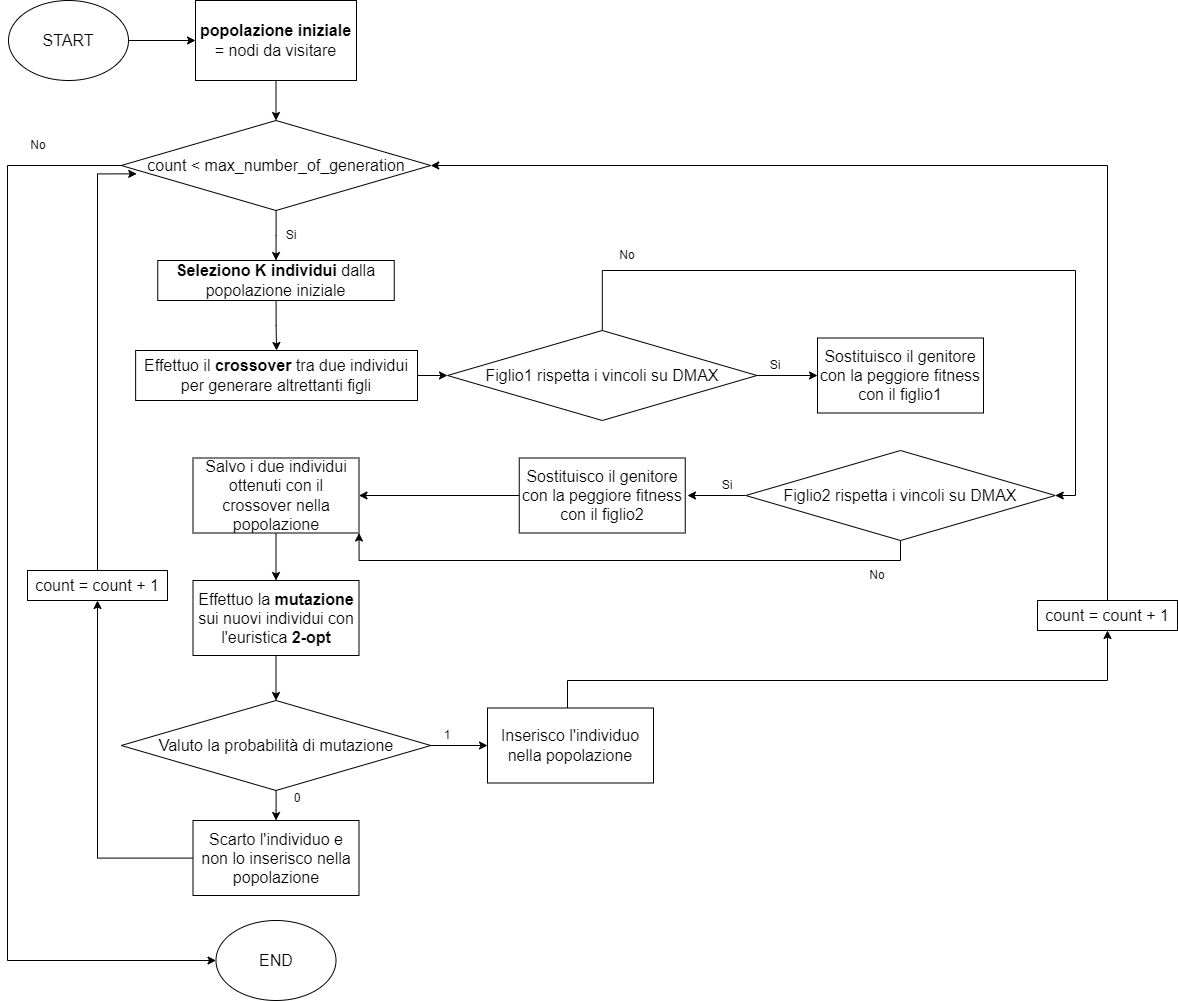
</div>
$\newline$

In [4]:
import time


#Inizializzo la popolazione
pop_list=[]

_start = time.time()
for i in range(population):
    
    temp_node=individual()
    
    while True:
        insert_location=temp_node.node_list.shape[0]-1
        node_list_temp=temp_node.node_list.copy()
        node_distance_temp=temp_node.distance.copy()
        node_TotalDistance_temp=temp_node.TotalDistance
        node_visited_temp=temp_node.visited.copy()
        node_unvisited_temp=temp_node.unvisited.copy()
        node_TotalPoint_temp=temp_node.TotalPoint

        node_list_temp, node_visited_temp, node_unvisited_temp, node_TotalPoint_temp, node_distance_temp, \
        node_TotalDistance_temp=insert_vertex(insert_location,node_list_temp,node_distance_temp,node_visited_temp,node_unvisited_temp,node_TotalPoint_temp,np.array([-1,-1,-1,-1]))

        if node_TotalDistance_temp>DMAX:
            break

        temp_node.reset(node_list_temp, node_visited_temp, node_unvisited_temp,node_distance_temp,node_TotalDistance_temp,node_TotalPoint_temp)
        temp_node.cal_fitness()

    pop_list.append(temp_node)


for count in range(max_number_of_generation):
    #Seleziono alcuni individui della popolazione
    selected_pop_list=[]

    for i in range(int(population/K)):
        
        for j in range(K):
            #la scelta nella lista è fatta con questa notazione (j*n_population/K:(j+1)*population/K)
            temp_pop_list=pop_list[j*int(population/K):(j+1)*int(population/K)].copy()
            best_fitness=0
            best_individual=None
            index=-1

            for k in range(tsize):
                
                while True:
                    tem_a=random.randint(0,int(population/K)-1)
                    if index!=tem_a:
                        index=tem_a
                        break

                selected_individual=copy.deepcopy(temp_pop_list[index])
                if selected_individual.fitness>=best_fitness:
                    best_fitness=selected_individual.fitness
                    best_individual=copy.deepcopy(selected_individual)
            
            selected_pop_list.append(best_individual)

    pop_list=selected_pop_list.copy()
    crossover_child=[]

    #Operatore di Crossover
    for i in range(int(population/2)):
        parent1_index=random.randint(0,len(pop_list)-1)
        parent2_index=copy.deepcopy(parent1_index)
                
        #Mi assicuro che i due genitori non siano la stessa persona
        while True:
            a_temp = random.randint(0, len(pop_list)-1)
            if a_temp!=parent2_index:
                parent2_index=a_temp
                break

        parent1=copy.deepcopy(pop_list[parent1_index])
        parent2=copy.deepcopy(pop_list[parent2_index])
        best_individual1=copy.deepcopy(parent1)
        best_individual2=copy.deepcopy(parent2)

        for j in range(1,len(parent1.node_list)-1):
            
            for k in range(1,len(parent2.node_list)-1):
                if parent1.node_list[j,0]==parent2.node_list[k,0]:
                    child1,child2=crossover(parent1,parent2,j,k)
                    
                    #Sostituisco uno dei due genitori con il figlio1 se rispetto il vincolo sulla distanza massima
                    if child1.TotalDistance<DMAX:
                        if best_individual1.fitness<best_individual2.fitness:
                            worse_of_best=copy.deepcopy(best_individual1)
                            tag=1
                        else:
                            worse_of_best=copy.deepcopy(best_individual2)
                            tag=2
                        if child1.fitness>worse_of_best.fitness and tag==1:
                            best_individual1=child1
                        elif child1.fitness>worse_of_best.fitness and tag==2:
                            best_individual2=child1

                    #Sostituisco uno dei due genitori con il figlio2 se rispetto il vincolo sulla distanza massima        
                    if child2.TotalDistance<DMAX:
                        if best_individual1.fitness<best_individual2.fitness:
                            worse_of_best=copy.deepcopy(best_individual1)
                            tag=1
                        else:
                            worse_of_best=copy.deepcopy(best_individual2)
                            tag=2
                        if child2.fitness>worse_of_best.fitness and tag==1:
                            best_individual1=child2
                        elif child2.fitness>worse_of_best.fitness and tag==2:
                            best_individual2=child2

        crossover_child.append(best_individual1)
        crossover_child.append(best_individual2)

    pop_list=crossover_child.copy()
    
    total_select=random.sample(range(0,population),int(population*0.3))
    
    for i in total_select:

        #Uso 2-opt per effettuare la mutazione del nuovo individuo
        old_individual=copy.deepcopy(pop_list[i])
        new_individual=TwoOpt(old_individual,DMAX)
        
        #Probabilità di scelta del nuovo individuo
        choice=random.randint(1,2)

        if choice==1:
            new_individual=inserting_mutation(new_individual,DMAX)
        else:
            new_individual=delete_mutation(new_individual,DMAX)

        pop_list[i]=new_individual

best_point=0
best_indi=None
for indi in pop_list:
    if indi.TotalPoint>best_point:
        best_point=indi.TotalPoint
        best_indi=indi

time_exec = round((time.time() - _start),5)
print('Punteggio: ' + str(best_individual.TotalPoint))
print('Distanza percorsa in km: ' + str(best_individual.TotalDistance))
print('Tempo impiegato: ' + str(time.time() - _start))
print('Percorso: ' + str(best_individual.node_list))

mytour=[]
for i in range(len(best_individual.node_list)):
    mytour.append([best_individual.node_list[i][1], best_individual.node_list[i][2]])

Punteggio: 62
Distanza percorsa in km: 0.028811328575765707
Tempo impiegato: 12.904980897903442
Percorso: [['Porta Marina' 14.4831917 40.7485259 0]
 ['Antiquarium di Pompei' 14.4833818 40.7482742 4]
 ['Tempio di Venere' 14.4837369 40.7484505 4]
 ['Basilica Pompeiana' 14.484459 40.74871749999999 5]
 ['Foro Triangolare' 14.48785 40.74851 5]
 ['Tempio della Fortuna Augusta' 14.4844556 40.75068609999999 4]
 ['Casa del Poeta Tragico' 14.4837825 40.75078550000001 3]
 ['Granai del Foro' 14.4842891 40.74969460000001 4]
 ['Santuario di Apollo' 14.4844212 40.7491871 5]
 ['Casa del Fauno' 14.4844303 40.7513657 3]
 ['Casa dei Vettii' 14.4845751 40.7521154 3]
 ["Casa dell'Orso Ferito" 14.48638560000001 40.7505894 3]
 ['Lupanare di Pompei' 14.4868047 40.7502816 3]
 ['Bakery' 14.4875724 40.7512239 2]
 ['Casa e Thermopolium di Vetutius Placidus' 14.4902611 40.7508351 2]
 ['Casa della Nave Europa' 14.49191 40.75052 3]
 ["Casa del Triclinio all'aperto" 14.4926588 40.7509034 3]
 ['Villa di Giulia Felice'

In [5]:
media_lat=0
media_long=0

for node in range(len(node_list)):
    media_lat = media_lat + float(node_list[node][1])
    media_long = media_long + float(node_list[node][2])
    
lat=media_lat/len(node_info)
long=media_long/len(node_info)

In [6]:
# Stampa del tour degli scavi di Pompei in linea d'aria 
import folium


map = folium.Map(location=[long,lat], zoom_start = zoom)
for i in range(len(best_individual.node_list)):
    folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = best_individual.node_list[i][0], 
                  icon=folium.Icon(color='darkred')).add_to(map)

points = []
for i in range(len(best_individual.node_list)):
    points.append((mytour[i][1],mytour[i][0]))

folium.PolyLine(points, color='darkred').add_to(map)

map

In [7]:
#Stampa del percorso per vie REALI 
#(ovviamente la distanza in km sarà leggermente diversa da quella in linea d'aria)
if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro"):
    import openrouteservice as ors
    import folium
    import folium.plugins as plugins

    
    # API Key di Open Route Service
    ors_key = '5b3ce3597851110001cf6248435cfcfbcf0c42858fde19dccf6f9c0f'

    # Richiesta dei servizi tramite API Key di ORS
    # Apro un Client per effettuare le richieste al Server di ORS
    client = ors.Client(key=ors_key)

    # Traccio il percorso
    route = client.directions(coordinates=mytour,
                              profile='foot-walking',
                              format='geojson')

    map = folium.Map(location=[long, lat], zoom_start = zoom)
    for i in range(len(best_individual.node_list)):
        if i == 0: 
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = best_individual.node_list[i][0], 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#b22222',
                                                    background_color='#b22222')).add_to(map)
        elif i == len(best_individual.node_list)-1:
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = best_individual.node_list[i][0], 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#ffd700',
                                                    background_color='#ffd700')).add_to(map)
        else:
            folium.Marker(location = (mytour[i][1],mytour[i][0]), tooltip = best_individual.node_list[i][0], 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    number=i,
                                                    border_color= '#b22222',
                                                    background_color='#ffffff')).add_to(map)

    # Aggiungo il GeoJson alla mappa
    folium.GeoJson(route, name=('Itinerario Scavi di Pompei con ' + str(DMAX) + ' ore'), 
                   style_function=lambda feature: {'color': 'darkred'}).add_to(map)

    # Aggiungo il livello del percorso alla mappa
    folium.LayerControl().add_to(map)

    print('Distanza percorsa in km: ' + str((route['features'][0]['properties']['summary']['distance'])/1000))

map

Distanza percorsa in km: 4.563899999999999


In [8]:
import csv


colonne = ['Istanza','DMAX','Metodo','N.POI','Lunghezza percorso (km)','Valore di soddisfazione (TOTALE)','Tempo di esecuzione (s)']
with open('./Confronti.csv', mode='a', newline='') as csv_file:
    
    writer = csv.DictWriter(csv_file, fieldnames=colonne)

    writer.writerow({'Istanza': namefile,'DMAX': DMAX,'Metodo': 'G.A.','N.POI': len(best_individual.node_list),'Lunghezza percorso (km)': round(best_individual.TotalDistance,5),'Valore di soddisfazione (TOTALE)': best_individual.TotalPoint, 'Tempo di esecuzione (s)': time_exec})
